<a href="https://colab.research.google.com/github/cweyandt/orb/blob/main/02%20EDA/eda_freezers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
# Mount google drive to list the raw data files

# Mounting the drive is straightforward but requires authentication each 
# time we reset the session
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/Capstone_Vacancy/data/'
# ! ls /content/drive/Shareddrives/Capstone_Vacancy/data

freezers = pd.read_pickle(drive_path + 'cleaned/' + 'freezers.pkl')
freezers.sort_index(axis=1, inplace=True)
freezers.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Floor                       1                      ...   2                    
Room                      130                      ... 230                    
Freezer                    03  04  05  07  08  09  ...  35  36  38  39  40  41
ts                                                 ...                        
2021-05-05 18:31:07-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:44-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:36:54-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:29-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN
2021-05-05 18:45:50-07:00 NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN

[5 rows x 61 columns]

There are many freezers but they are all contained within one of three rooms. It is perfectly reasonable to group the data by room or floor, however the individual problematic sensors must be removed before the grouping occurs.

In [62]:
freezers.groupby(by='Room', axis=1).sum().resample('5min').sum().head()

Room,130,149,230
ts,,,
2020-05-06 14:40:00-07:00,0.0,0.0,1.0
2020-05-06 14:45:00-07:00,0.0,0.0,2.0
2020-05-06 14:50:00-07:00,0.0,0.0,0.0
2020-05-06 14:55:00-07:00,0.0,0.0,0.0
2020-05-06 15:00:00-07:00,0.0,0.0,0.0


`groupby(by='Room', axis=1).sum()` is an example of how to group multiple individual sensors by room using the MultiIndex.  `axis=1` groups on columns
  
`freezers['2020-11':'2021-01']` is an example of slicing by time. dateTime arguments are fairly flexible, allowing strings that can be parsed into dateTime objects. 

`freezers.xs(level='Room', key='149', axis=1)` will subset (cross-sectoion) all columns with MultiIndex `'Room' == '149'`. Note that both arguments are strings.  

`freezers.resample('5min').max()` will group on timestamp at 5 minute intervals. `max()` is used as an aggregation, in this case making it an _any_ aggregation of boolean events.



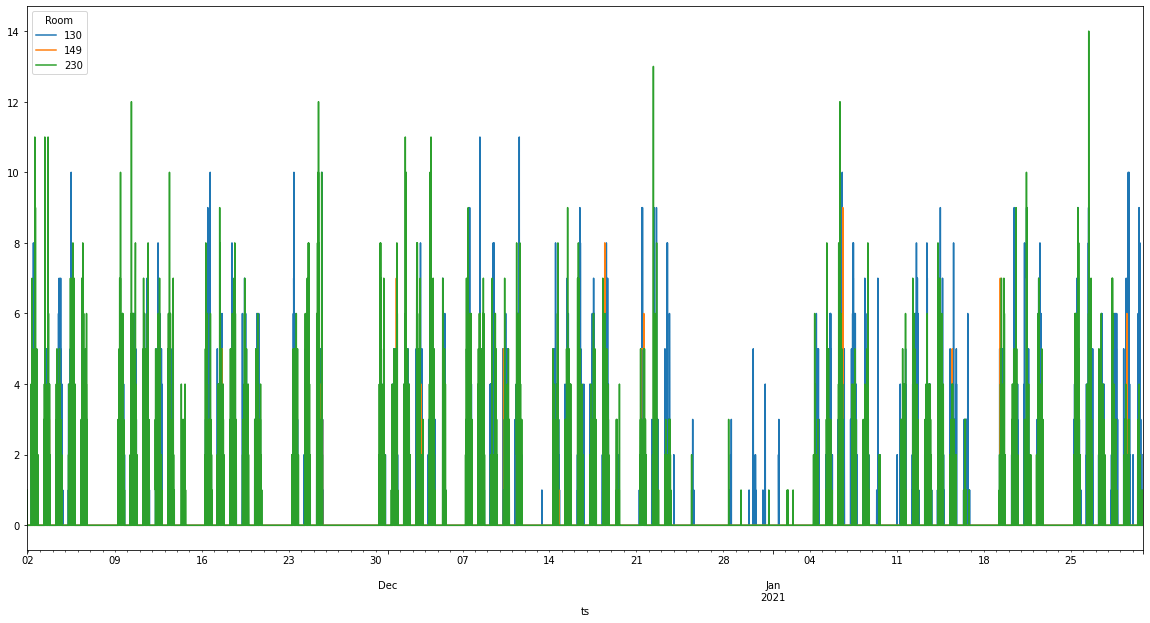

In [63]:
freezers['2020-11':'2021-01'].groupby(by='Room', axis=1).sum().resample('5min').sum().plot(stacked=False)

When the series are not stacked it is difficult to identify where the bad sensors are

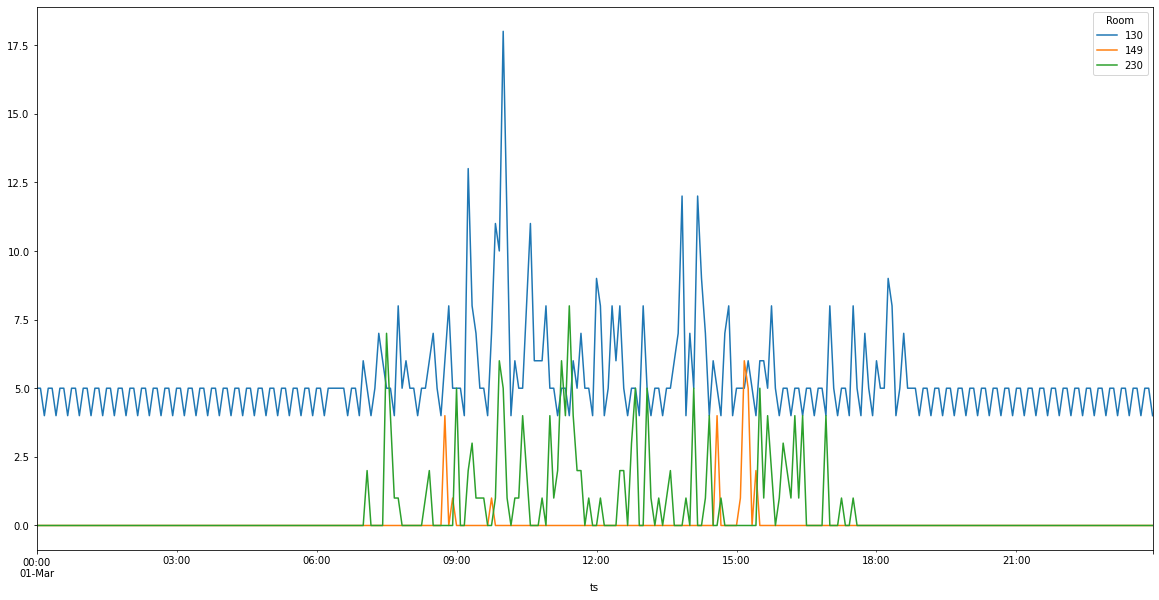

In [64]:
freezers['2021-03-01'].groupby(by='Room', axis=1).sum().resample('5min').sum().plot(stacked=False)

but once you stack them you can see how aggregations propgate signal issues from bad sensors. in this case, it appears that there is a sensor in Room 130 that is triggering every one minute. Since the data has been aggregated at 5min with a sum function, the single sensor registers 5 events per period. Most likely, this is a sensor that was disconnected from a freezer that was being replaced or repaired, so the sensor continually reports that 'the door is open' once per minute'.  

Because there are so many sensors in this aggregation, it is reasonable to remove the sensor completely from the dataset. In a streaming application, however, it will be necessary to recognize that the sensor is bad and temporarily remove it from the calculations. Note that this particular issue is only present for a few weeks out of the full year data series.

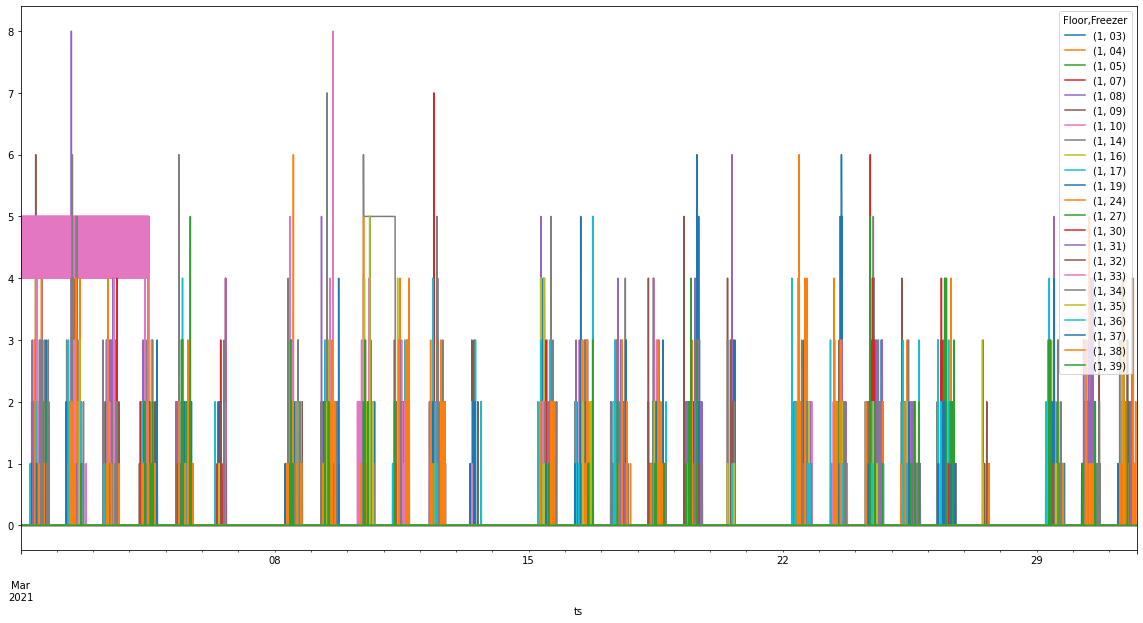

In [71]:
freezers.xs(level="Room", key='130', axis=1)['2021-03'].resample('5min').sum().plot(stacked=False, legend=True)

Digging into the individual freezer sensors within Room 130 we are able to see that there are two (0bvious) events where freezer sensors were continually reporting an open door. The first (pink) series reported 4-5 events per period for the first 4 days of the month, then returned to normal operation. There is also a horizontal grey line on the 11th, where it appears that a freezer may have been left ajar overnight. The first is easy to spot from a high-level plot but the smaller events should be identified programatically.

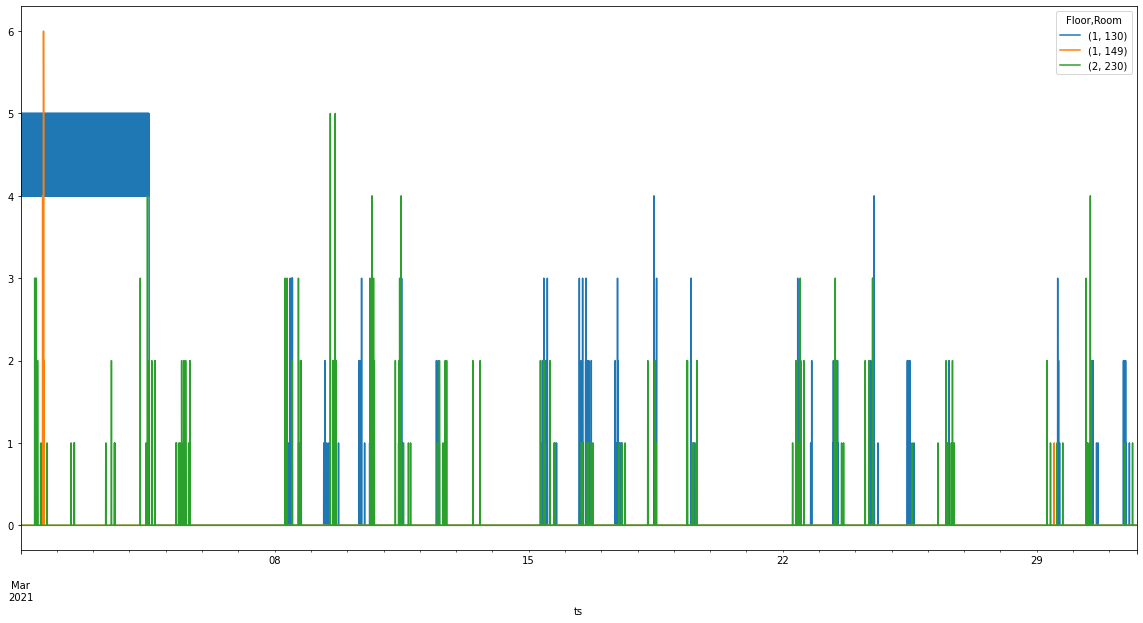

In [66]:
freezers.xs(level="Freezer", key='10', axis=1)['2021-03'].resample('5min').sum().plot(stacked=False, legend=True)

Here I just selected Freezer #10 but did not specify the Room or Floor, so I got three different freezers with that ID.

In [72]:
freezers.xs(key=('1','130','10'), axis=1)['2021-03-01']

Floor,1
Room,130
Freezer,10
ts,
2021-03-01 00:00:03-08:00,1.0
2021-03-01 00:01:08-08:00,1.0
2021-03-01 00:02:12-08:00,1.0
2021-03-01 00:03:16-08:00,1.0
2021-03-01 00:04:21-08:00,1.0
...,...
2021-03-01 23:54:43-08:00,1.0


Above output shows an example of a freezer that is reporting open status every ~minute.

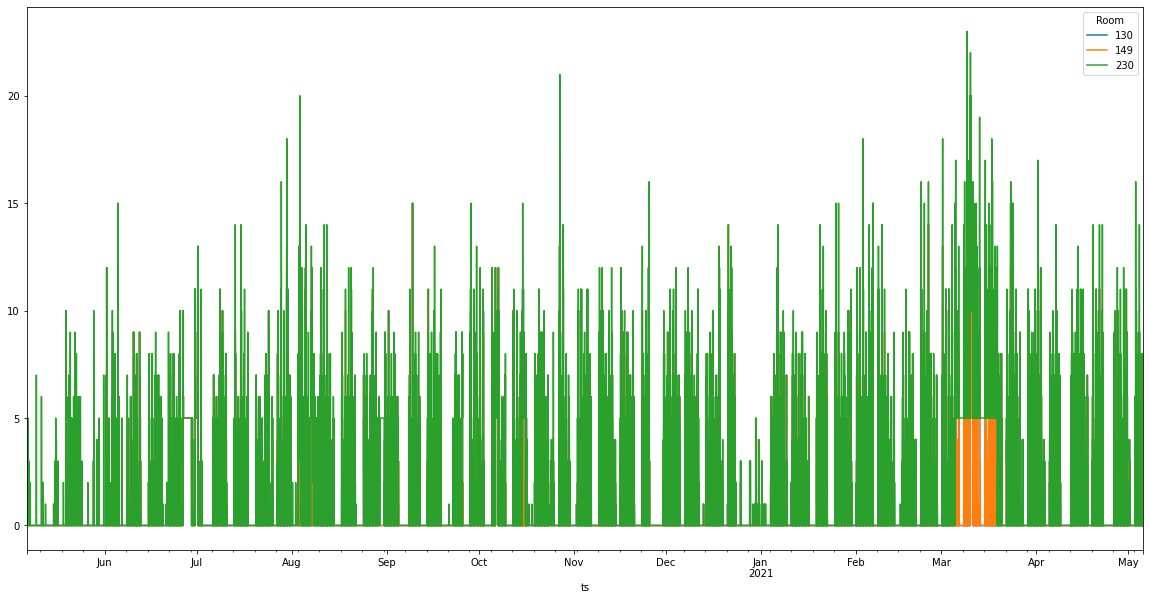

In [73]:
freezers.drop(labels=('1','130','10'), axis=1).groupby(by='Room', axis=1).sum().resample('5min').sum().plot(stacked=True)

We got rid of (dropped) the most obvious freezer from the series, but it appears there is also a bad signal in Room 149 during March.

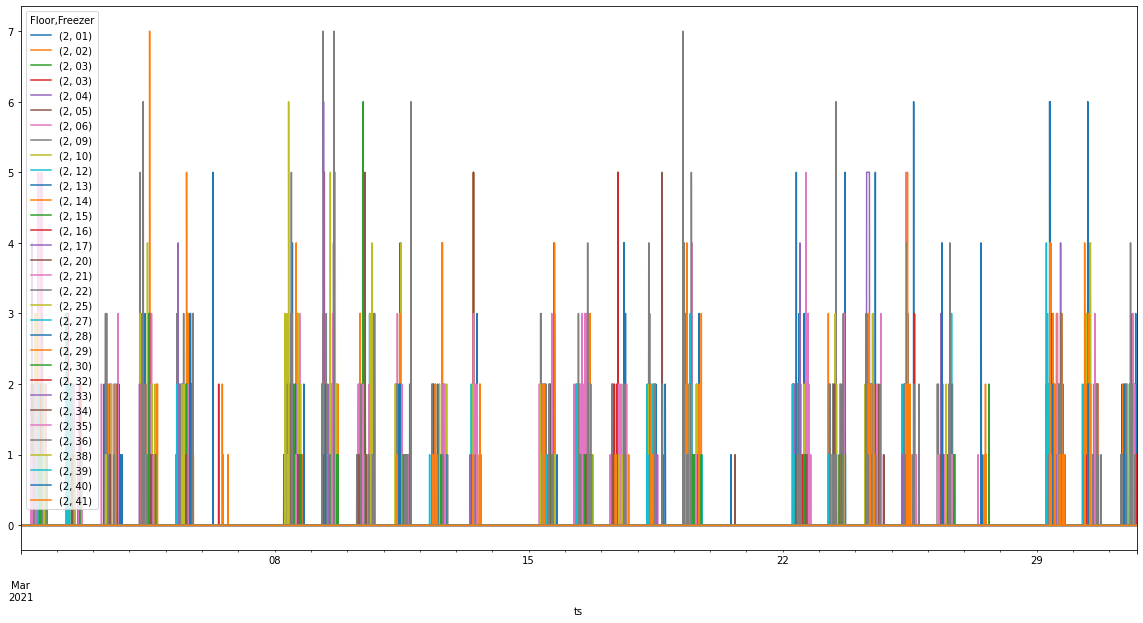

In [74]:
freezers.drop(labels=('2','230','08'), axis=1).xs(level="Room", key='230', axis=1)['2021-03'].resample('5min').sum().plot(stacked=False, legend=True)

In [76]:
# Remove two bad signals
freezers = freezers.drop(labels=[('1','130','10'),('2','230','08')], axis=1)

KeyError: ignored

Got rid of those two entirely, although it would be better to do it with some sort of loop that can recognize repeated signals from a single sensor, without likewise removing real signals.  

This is partly a result of how the original data file was processed, in which only the ***TRUE*** timestamps were retained. This data could be reprocessed to include the ***FALSE*** timestamped events as well, which would show the door actually closing.

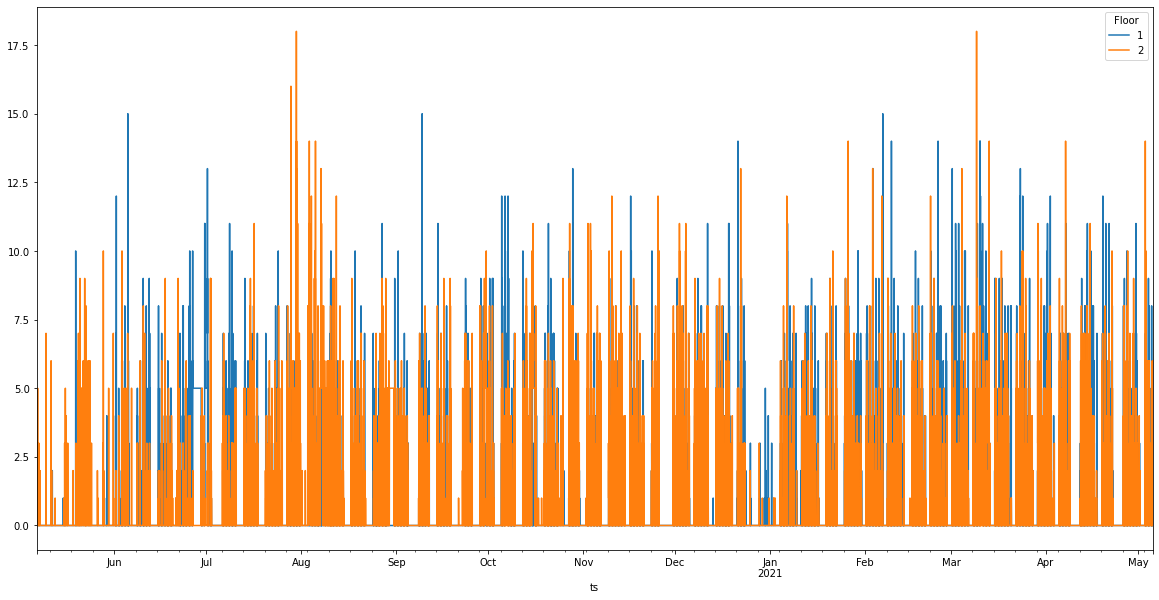

In [38]:
freezers.groupby(by='Floor', axis=1).sum().resample('5min').sum().plot(stacked=False)

Regrouping by floor, after having removed the two bad sensors

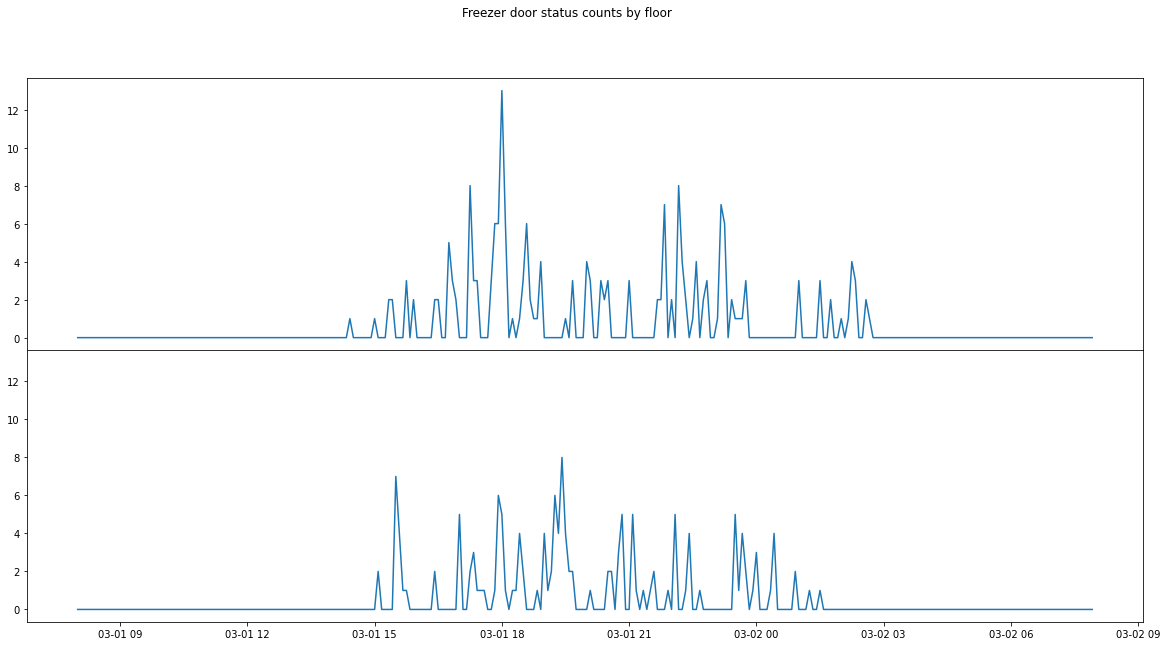

In [77]:
# Attempt a facet_grid type plot showing each floor

data = freezers['2021-03-01'].groupby(by='Floor', axis=1).sum().resample('5min').sum()

fig, axs = plt.subplots(data.columns.size, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
fig.suptitle('Freezer door status counts by floor')

for ax in range(data.columns.size):
  axs[ax].plot(data[data.columns[ax]])

# Note that the X axis is not reading proper dateTime. It is displaying in UTC.

The X axis got screwed up, reverting to UTC time and displaying differently that previous plots.